# Podstawy Gymnasium

# Podstawy Gymnasium

### Autorzy: Jakub Kot, Dawid Małecki

## Cel ćwiczenia
Wykorzystanie podstawowych funkcji biblioteki Gymnasium do stworzenia prostego modelu nauki agenta w środowisku.

## Opis problemu
Zadanie polega na stworzeniu agenta, który będzie chciał zmaksymalizować funkcję nagrody w środowisku. Agent będzie dokonywał decyzji o wyborze akcji na podstawie obserwacji ze środowiska. Po zakończeniu pojedynczej gry agent będzie uczył się na podstawie swoich doświadczeń wykorzystując uczenie przez wzmacnianie.

## Rozwiązanie problemu

## Środowisko dyskretne
Agent uczy się optymalnej gry w blackjacka

In [1]:
from __future__ import annotations

import random

from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.distributions.normal import Normal

import gymnasium as gym

plt.rcParams["figure.figsize"] = (10, 5)


In [18]:
class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [29]:
# hyperparameters
learning_rate = 0.01
n_episodes = 1_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1
discount_factor = 0.9

env = gym.make('Blackjack-v1', natural=True, sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount_factor
)

In [30]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|          | 0/1000000 [00:00<?, ?it/s]

### Rezultaty

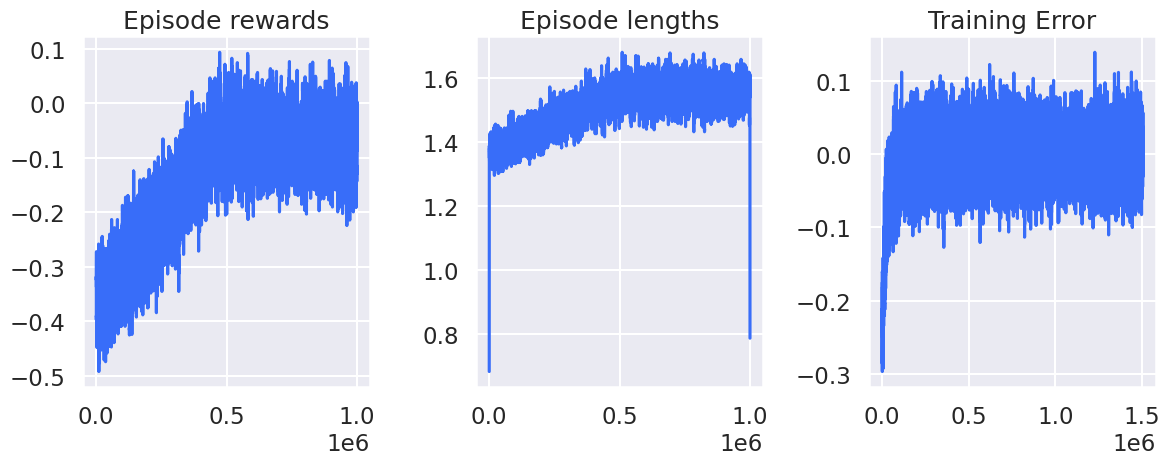

In [31]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

## Środowisko ciągłe
Agent uczy się optymalnego sterowania pająkiem.

In [11]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes a neural network that estimates the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """
        super().__init__()

        hidden_space1 = 16  # Nothing special with 16, feel free to change
        hidden_space2 = 32  # Nothing special with 32, feel free to change

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        # Policy Std Dev specific Linear Layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Conditioned on the observation, returns the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            x: Observation from the environment

        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddevs

In [16]:
class REINFORCE:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int, gamma: int = 0.99):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand (Inverted Pendulum v4).

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 1e-3  # Learning rate for policy optimization
        self.gamma = gamma  # Discount factor
        self.eps = 1e-6  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)
        
        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

    def update_learning_rate(self, episode):
        self.optimizer.param_groups[0]["lr"] = self.learning_rate * (1 - episode / 5000)

In [17]:
def train_env(env: gym.Env, num_episodes: int = 1000, discount_rate: int = 0.99, state_dict: dict = None, save_path: str = None):
    # Create and wrap the environment
    wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

    total_num_episodes = int(num_episodes)  # Total number of episodes
    # Observation-space of Ant-v4 (4)
    obs_space_dims = env.observation_space.shape[0]
    # Action-space of Ant-v4 (1)
    action_space_dims = env.action_space.shape[0]
    rewards_over_seeds = []

    # initialize the agent
    agent = REINFORCE(obs_space_dims, action_space_dims, gamma=discount_rate)

    # alternatively load the model
    if state_dict:
        agent.net.load_state_dict(torch.load("reinforce_ant.pth"))

    for seed in [1]:  # Fibonacci seeds
        # set seed
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        # Reinitialize agent every seed
        reward_over_episodes = []

        for episode in tqdm(range(total_num_episodes)):
            # gymnasium v26 requires users to set seed while resetting the environment
            obs, info = wrapped_env.reset(seed=seed)

            done = False
            while not done:
                action = agent.sample_action(obs)

                # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
                # These represent the next observation, the reward from the step,
                # if the episode is terminated, if the episode is truncated and
                # additional info from the step
                obs, reward, terminated, truncated, info = wrapped_env.step(action)
                agent.rewards.append(reward)

                # End the episode when either truncated or terminated is true
                #  - truncated: The episode duration reaches max number of timesteps
                #  - terminated: Any of the state space values is no longer finite.
                done = terminated or truncated

            reward_over_episodes.append(wrapped_env.return_queue[-1])
            agent.update()
            agent.update_learning_rate(episode+1)

            if (episode+1) % 500 == 0:
                avg_reward = int(np.mean(wrapped_env.return_queue))
                print("Episode:", episode+1, "Average Reward:", avg_reward, "Learning rate:", agent.learning_rate)

        rewards_over_seeds.append(reward_over_episodes)

    if save_path:
        torch.save(agent.net.state_dict(), save_path)
    
    return rewards_over_seeds

## Rezultaty

In [21]:
env = gym.make("Ant-v4")
rewards_over_seeds90 = train_env(env, num_episodes=1500, discount_rate=0.90, save_path="reinforce_ant_90.pth")

  0%|          | 0/1500 [00:00<?, ?it/s]

Episode: 500 Average Reward: 779 Learning rate: 0.001
Episode: 1000 Average Reward: 652 Learning rate: 0.001
Episode: 1500 Average Reward: 738 Learning rate: 0.001


/home/jakub/anaconda3/envs/intobl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jakub/anaconda3/envs/intobl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


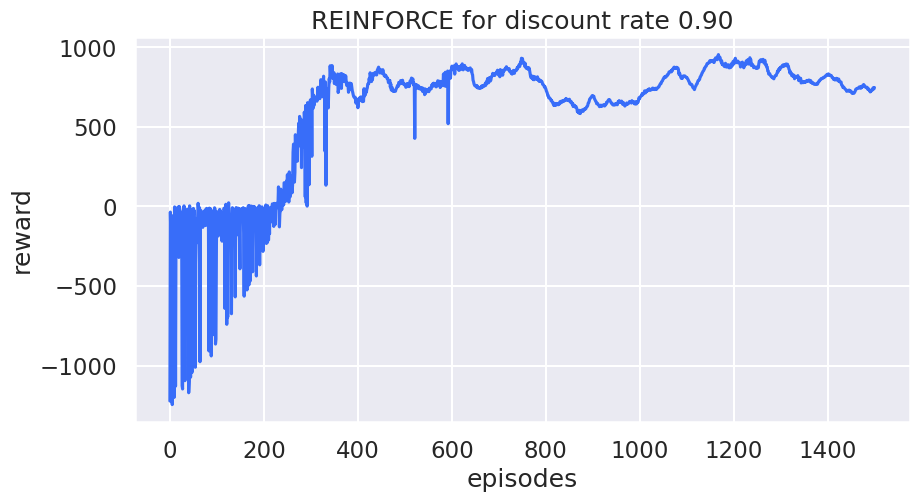

In [22]:
rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds90]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for discount rate 0.90"
)
plt.show()

In [23]:
env = gym.make("Ant-v4")
rewards_over_seeds95 = train_env(env, num_episodes=1500, discount_rate=0.95, save_path="reinforce_ant_95.pth")

  0%|          | 0/1500 [00:00<?, ?it/s]

Episode: 500 Average Reward: -53 Learning rate: 0.001
Episode: 1000 Average Reward: 732 Learning rate: 0.001
Episode: 1500 Average Reward: 766 Learning rate: 0.001


/home/jakub/anaconda3/envs/intobl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jakub/anaconda3/envs/intobl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


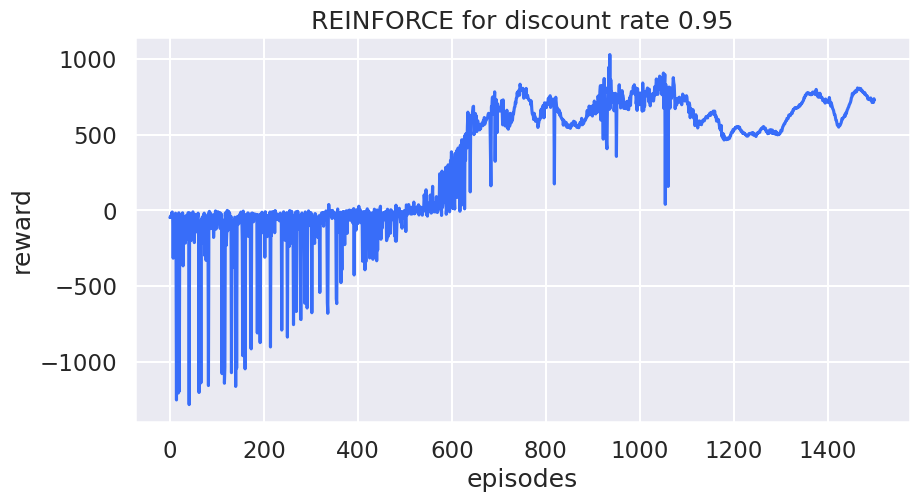

In [24]:
rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds95]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for discount rate 0.95"
)
plt.show()

In [25]:
env = gym.make("Ant-v4")
rewards_over_seeds99 = train_env(env, num_episodes=1500, discount_rate=0.99, save_path="reinforce_ant_99.pth")

  0%|          | 0/1500 [00:00<?, ?it/s]

Episode: 500 Average Reward: -126 Learning rate: 0.001
Episode: 1000 Average Reward: -116 Learning rate: 0.001
Episode: 1500 Average Reward: -59 Learning rate: 0.001


/home/jakub/anaconda3/envs/intobl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jakub/anaconda3/envs/intobl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


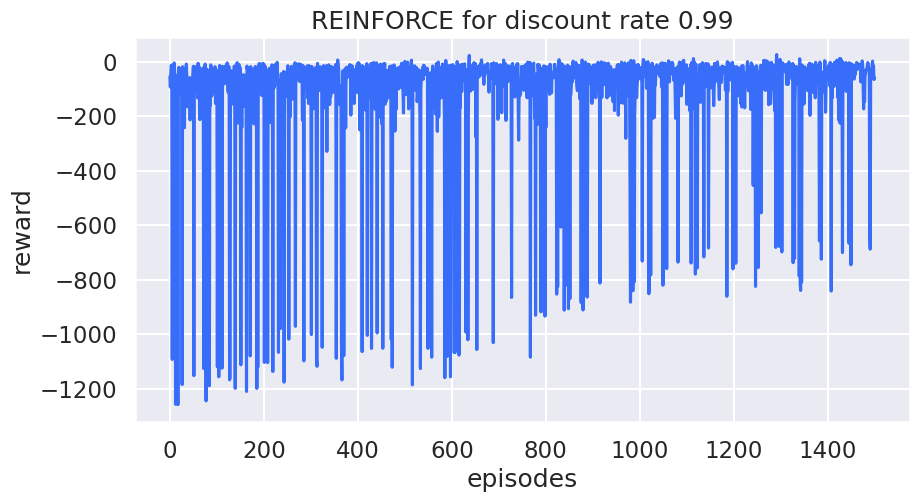

In [26]:
rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds99]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for discount rate 0.99"
)
plt.show()

## Porównanie dwóch algorytmów
Porównanie dwóch algorytmów dla środowiska dyskretnego (blackjack).

Porównywane algorytmy to Q-Learning i Deep Q-Learning.

Hiperparametry zostały zoptymalizowane dla jak najlepszych rezultatów dla pierwszych 100 000 gier (przy mniejszej ilości agent nie jest w stanie się zbyt wiele nauczyć).

In [8]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class BlackjackAgentDeep:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95
    ):
        self.q_network = DQN(3, env.action_space.n)
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            obs = torch.FloatTensor(obs)
            with torch.no_grad():
                return int(self.q_network(obs).argmax().item())

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        obs = torch.FloatTensor(obs)
        next_obs = torch.FloatTensor(next_obs)
        reward = torch.FloatTensor([reward])
        action = torch.LongTensor([action])

        if terminated:
            target_q_value = reward
        else:
            target_q_value = reward + self.discount_factor * self.q_network(next_obs).max()

        predicted_q_value = self.q_network(obs)[action]

        loss = self.criterion(predicted_q_value, target_q_value)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.training_error.append(loss.item())

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [14]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.05
discount_factor = 0.9

env = gym.make('Blackjack-v1', natural=True, sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

agent = BlackjackAgentDeep(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount_factor
)

In [15]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(obs, action, reward, terminated, next_obs)

        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|          | 0/100000 [00:00<?, ?it/s]

## Rezultaty Deep Q-Learning

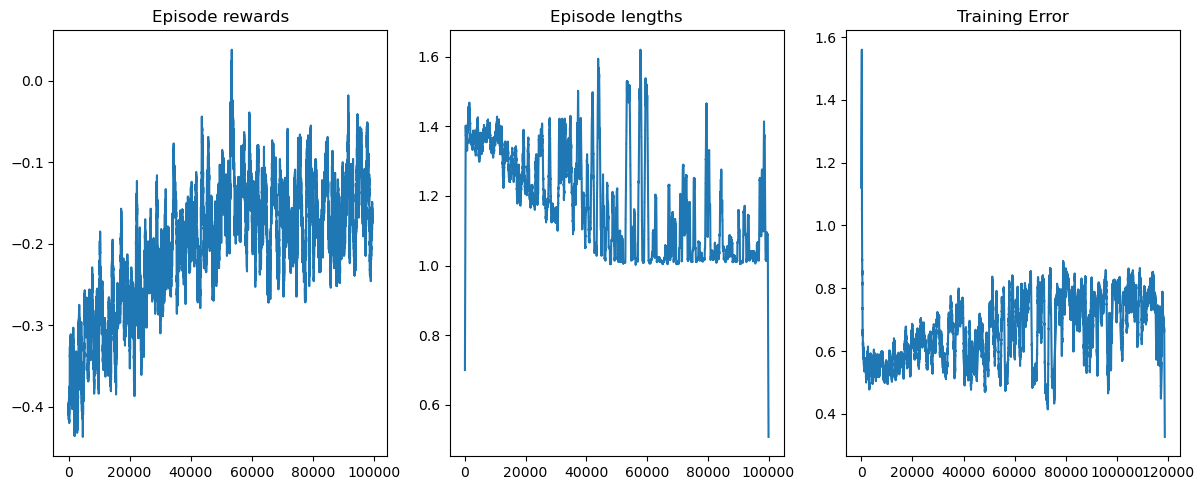

In [16]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [19]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.05
discount_factor = 0.9

env = gym.make('Blackjack-v1', natural=True, sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount_factor
)

In [20]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|          | 0/100000 [00:00<?, ?it/s]

## Rezultaty Q-Learning

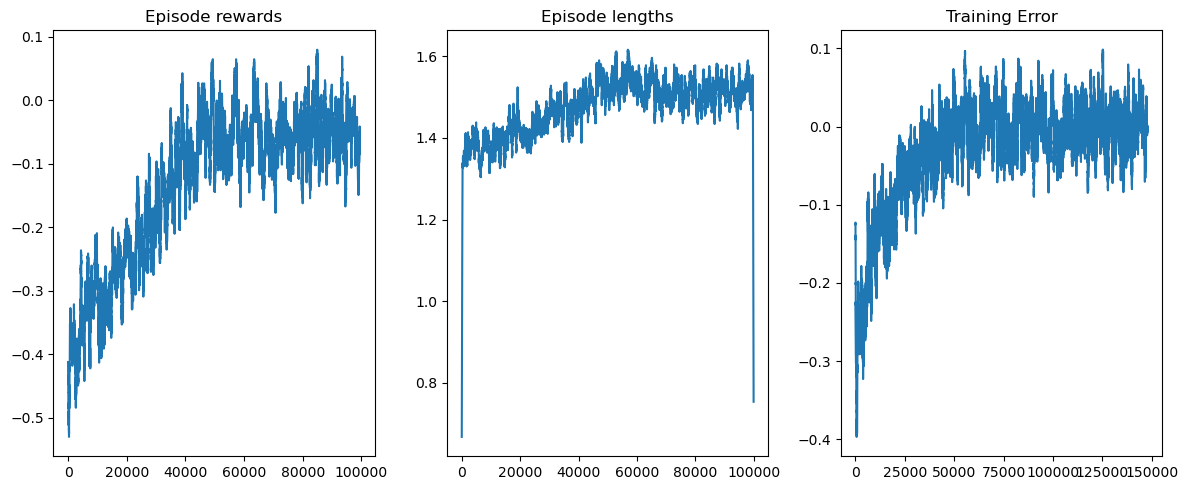

In [21]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

## Wnioski
- Agent grający w blackjacka bardzo szybko się uczy, co wynika z prostoty środowiska.
- W środowisku ciągłym discount rate 0.90 i 0.95 przynoszą satysfacjonujące rezultaty.
- Discount rate 0.99 zaś jest zbyt wysoki, co skutkuje bardzo powolną nauką agenta.
- Algorytm Deep-Q Learning uczy się wolniej niż Q-Learning. W bardziej skomplikowanym środowisku powinien ostatecznie osiągać lepsze rezultaty, jednak dla blackjacka Q-Learning jest lepszym wyborem. 